In [2]:
# %matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [3]:
dt = 0.01
simulation_time = 10
time_steps = int(simulation_time/dt)

# Wafer and cooling parameters
alpha = 0.01 # Thermal diffusivity
wafer_size = 1 # Size of the quarter of the wafer. !!! Needs to be adjusted
# 45.6 = 2* 22.8 since it is the average of the wafer intially
center_temp_initial = 28  # Initial center temperature
edge_temp_initial = 17.6  # Initial edge temperature
reference_temp = 22  # Desired center temperature

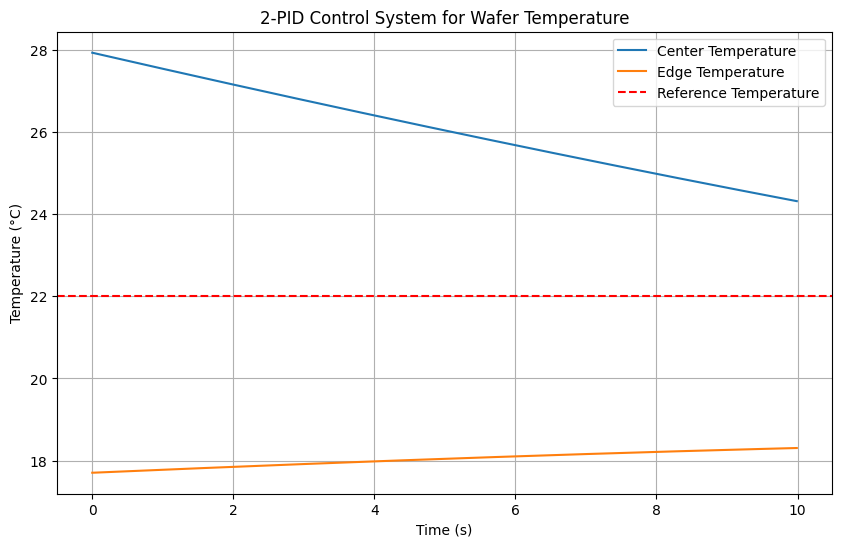

In [4]:
# PID gains
kp1, ki1, kd1 = 2.0, 0.1, 1.0  # PID gains for center temperature control
kp2, ki2, kd2 = 2.5, 0.1, 1.0  # PID gains for edge temperature control

# Initial conditions
center_temp = center_temp_initial
edge_temp = edge_temp_initial
center_temp_history = []
edge_temp_history = []
time_history = []

# PID control states
center_integral = 0
center_prev_error = 0
edge_integral = 0
edge_prev_error = 0

def plant(temp, control_signal, diffusivity=alpha):
    """Simulates the plant's response to the control signal."""
    # Simple heat diffusion model
    dtemp_dt = -diffusivity * (temp - control_signal)
    return dtemp_dt

def pid_controller(setpoint, measured_value, kp, ki, kd, integral, prev_error, dt):
    """PID controller implementation."""
    error = setpoint - measured_value
    integral += error * dt
    derivative = (error - prev_error) / dt
    output = kp * error + ki * integral + kd * derivative
    return output, integral, error

# Simulation loop
for t in range(time_steps):
    current_time = t * dt

    # Step 1: PID control for center temperature
    center_control_signal, center_integral, center_prev_error = pid_controller(
        reference_temp, center_temp, kp1, ki1, kd1, center_integral, center_prev_error, dt
    )
    center_temp += plant(center_temp, center_control_signal) * dt

    # Step 2: PID control for edge temperature
    edge_control_signal, edge_integral, edge_prev_error = pid_controller(
        center_temp, edge_temp, kp2, ki2, kd2, edge_integral, edge_prev_error, dt
    )
    edge_temp += plant(edge_temp, edge_control_signal) * dt

    # Record history
    center_temp_history.append(center_temp)
    edge_temp_history.append(edge_temp)
    time_history.append(current_time)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(time_history, center_temp_history, label="Center Temperature")
plt.plot(time_history, edge_temp_history, label="Edge Temperature")
plt.axhline(reference_temp, color='r', linestyle='--', label="Reference Temperature")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (°C)")
plt.title("2-PID Control System for Wafer Temperature")
plt.legend()
plt.grid()
plt.show()
